In [1]:
# Imports
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import factorial
import peakutils
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

import qcodes.instrument.parameter as parameter

loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

ERROR! Session/line number was not unique in database. History logging moved to new session 114


In [126]:
def try_close_instruments(instruments=['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        
    
def plot_traces(traces, traces_AWG=None):
    plt.figure()
    plt.pcolormesh(range(traces.shape[1]), 
                 range(traces.shape[0]+1), traces)
    if traces_AWG is not None:
        trace_AWG = traces_AWG[:1]
        trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
        trace_AWG -= np.min(trace_AWG)
        plt.pcolormesh(range(traces.shape[1]), 
                       np.array([0,1])+traces.shape[0], trace_AWG)
    plt.xlim([0,traces.shape[1]])
    plt.ylim([0,traces.shape[0]+1])
    plt.colorbar()

    fig, axes = plt.subplots(len(traces), sharex=True)
    for k, trace in enumerate(traces):
        axes[k].plot(trace)
        axes[k].plot(trace > 0.5)
        if traces_AWG is not None:
            trace_AWG = traces_AWG[k]
            trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
            trace_AWG -= np.min(trace_AWG)
            axes[k].plot(trace_AWG)
        else:
            axes[k].plot([1]*load_pts+[0.5]*read_pts+[0]*empty_pts)
    
dummy = parameter.ManualParameter(name="dummy")

In [90]:
# Load ats instruments
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver
# import qcodes.personal.meta_instruments.

for instrument_name in ['ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))
ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

#Default ATS and ATS_controller settings
# Configure ATS and ATS_controller
ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=145,
           trigger_slope1='TRIG_SLOPE_POSITIVE',
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')

read_length=0.03
plot = True

ATS_controller.average_mode('none')
samples_per_record = int(16 * round(float(ATS.sample_rate()*read_length)/16))
ATS_controller.update_acquisition_kwargs(buffer_timeout=5000,
                                         samples_per_record=samples_per_record,
                                         records_per_buffer=1,
                                         buffers_per_acquisition=4,
                                         channel_selection='AC')

load_duration = 5 # ms
read_duration = 20 # ms
empty_duration = 5 # ms

load_pts = round(load_duration/1e3*ATS.sample_rate())
read_pts = round(read_duration/1e3*ATS.sample_rate())
empty_pts = round(empty_duration/1e3*ATS.sample_rate())



Wall time: 309 ms


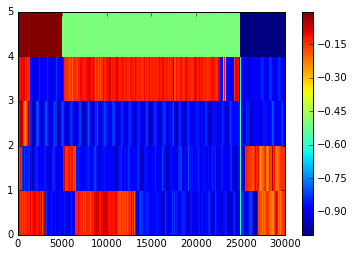

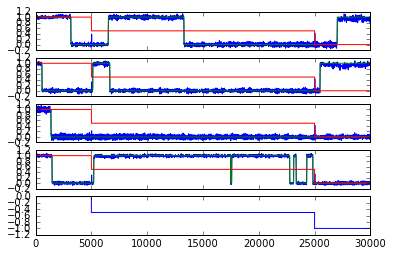

In [114]:
plot = True
ATS_controller.update_acquisition_kwargs(records_per_buffer=1,
                                         buffers_per_acquisition=4)

%time traces, traces_AWG = ATS_controller.acquisition()
traces_load = traces[:,:load_pts]
traces_read = traces[:,load_pts:load_pts+read_pts]
traces_empty = traces[:,load_pts+read_pts:]

if plot:
    plot_traces(traces, traces_AWG)

In [130]:

from meta_instruments import Analysis
reload(Analysis)
lre_analysis = Analysis.LoadReadEmptyAnalysis('LRE_analysis', ATS_controller=ATS_controller, server_name=None)
lre_analysis.load_duration(load_duration)
lre_analysis.read_duration(read_duration)
lre_analysis.empty_duration(empty_duration)